   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.4 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


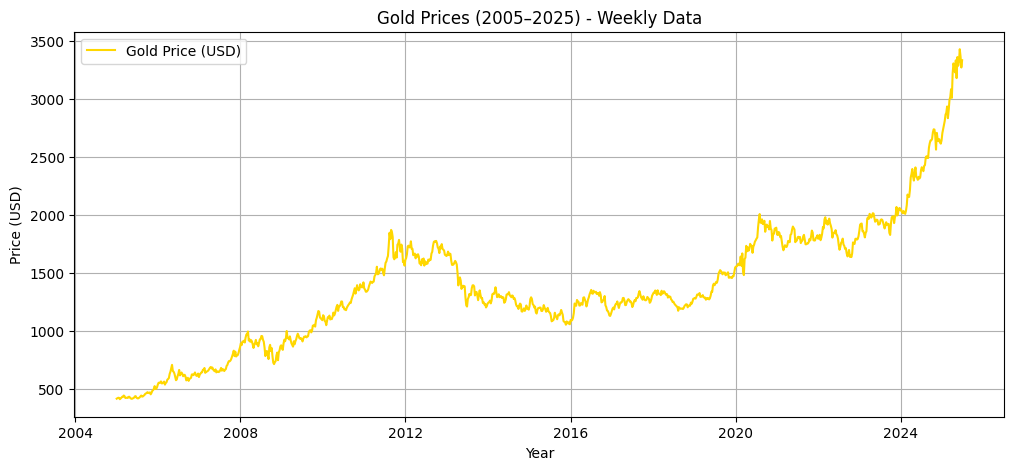

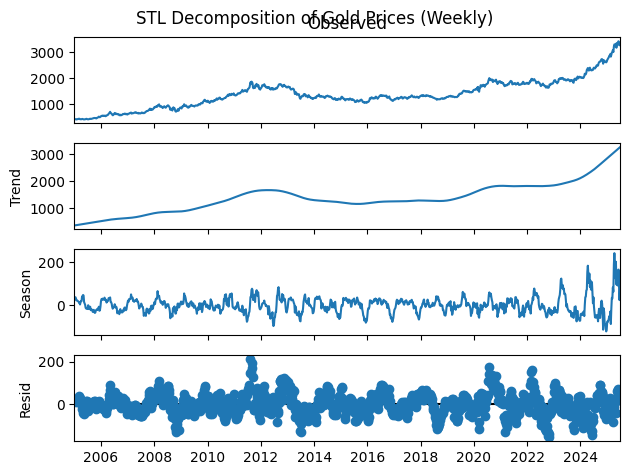

ADF Statistic: 1.5751277158719685
p-value: 0.9977810047822482


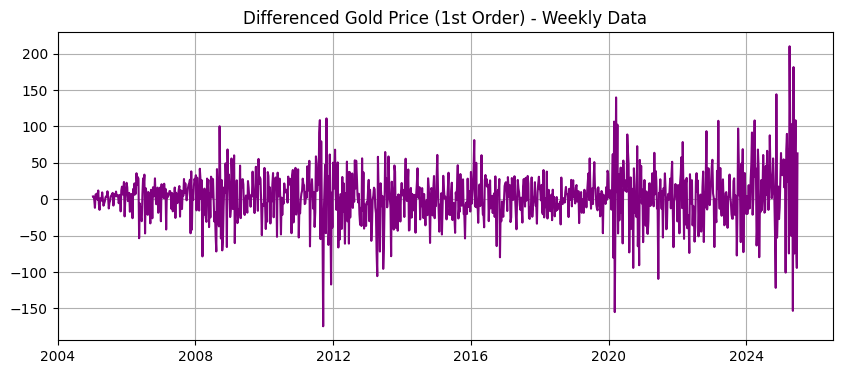


ARIMA Model Summary (Weekly Data):

                               SARIMAX Results                                
Dep. Variable:                   GC=F   No. Observations:                 1070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5300.579
Date:                Fri, 18 Jul 2025   AIC                          10607.159
Time:                        18:14:41   BIC                          10622.082
Sample:                    01-01-2005   HQIC                         10612.812
                         - 06-28-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1130      0.321     -0.352      0.724      -0.742       0.516
ma.L1          0.0463      0.326      0.142      0.887      -0.593       0.685
sigma2      118

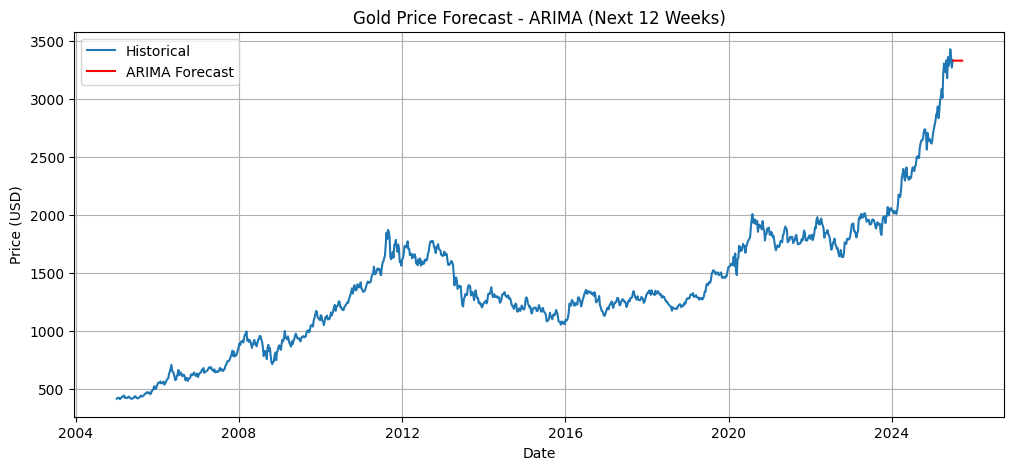


SARIMA Model Summary (Weekly Data):

                                     SARIMAX Results                                      
Dep. Variable:                               GC=F   No. Observations:                 1070
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -5125.418
Date:                            Fri, 18 Jul 2025   AIC                          10260.836
Time:                                    18:15:53   BIC                          10285.459
Sample:                                01-01-2005   HQIC                         10270.187
                                     - 06-28-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2718      0.253      1.075      0.282      -0.224       0.7

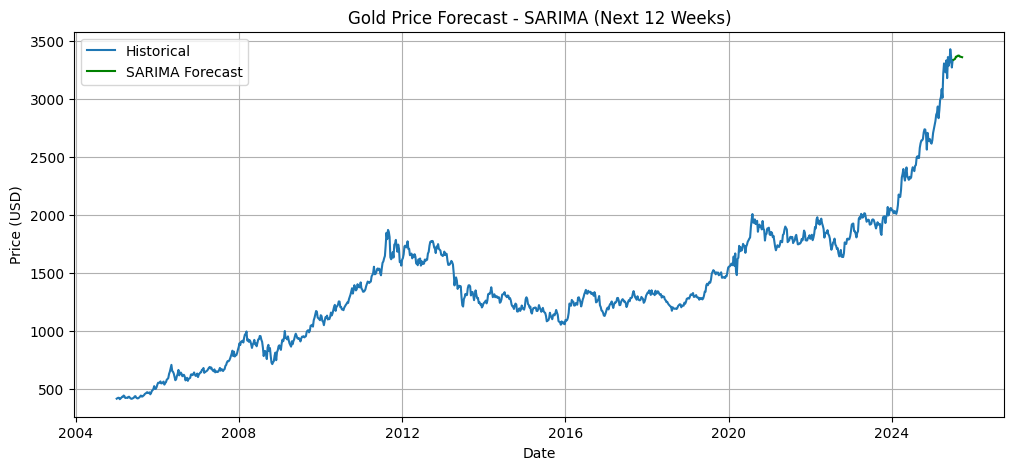

✅ Saved optimized ARIMA model
✅ Saved optimized SARIMA model


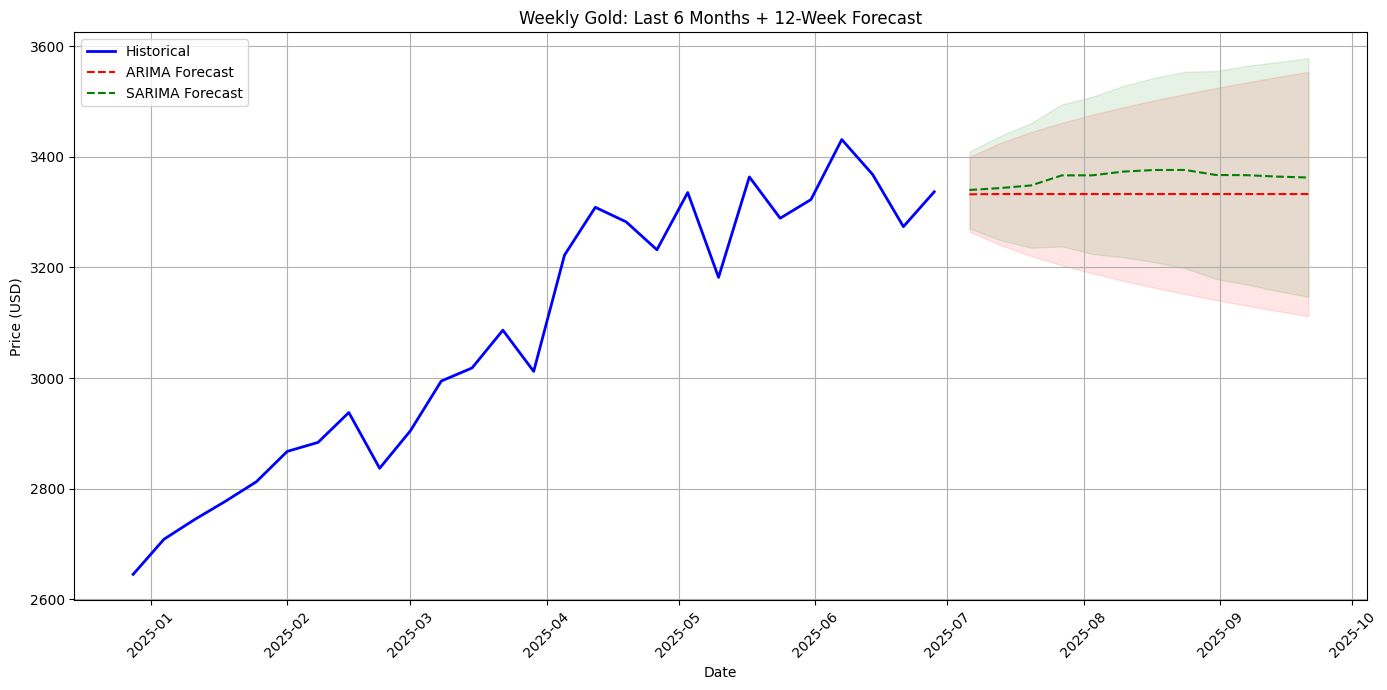

In [4]:
# ----------------------------------------------
# Step 1: Install and import necessary libraries
# ----------------------------------------------
!pip install yfinance statsmodels matplotlib pandas joblib --quiet
!pip install lz4  # Alternative high-performance compression

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------------
# Step 2: Download gold price data (WEEKLY)
# ----------------------------------------------
gold_data = yf.download("GC=F", start="2005-01-01", end="2025-07-01", interval="1wk")
gold = gold_data[['Close']].copy().rename(columns={'Close': 'Price'}).dropna()

# ----------------------------------------------
# Step 3: Plot the time series
# ----------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(gold, label='Gold Price (USD)', color='gold')
plt.title("Gold Prices (2005–2025) - Weekly Data")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()

# ----------------------------------------------
# Step 4: STL Decomposition (Trend + Seasonality)
# ----------------------------------------------
# For weekly data, we'll use period=52 (weeks in a year)
stl = STL(gold['Price'], period=52)
result = stl.fit()
result.plot()
plt.suptitle("STL Decomposition of Gold Prices (Weekly)")
plt.show()

# ----------------------------------------------
# Step 5: ADF Test for Stationarity
# ----------------------------------------------
adf_result = adfuller(gold['Price'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
# p > 0.05 → not stationary → we'll use differencing

# ----------------------------------------------
# Step 6: Differencing to Make Series Stationary
# ----------------------------------------------
gold_diff = gold['Price'].diff().dropna()

plt.figure(figsize=(10, 4))
plt.plot(gold_diff, color='purple')
plt.title("Differenced Gold Price (1st Order) - Weekly Data")
plt.grid(True)
plt.show()

# ----------------------------------------------
# Step 7: Fit ARIMA Model (Basic)
# ----------------------------------------------
model_arima = ARIMA(gold['Price'], order=(1, 1, 1))
model_arima_fit = model_arima.fit()
print("\nARIMA Model Summary (Weekly Data):\n")
print(model_arima_fit.summary())

# ----------------------------------------------
# Step 8: Forecast using ARIMA (Next 12 Weeks)
# ----------------------------------------------
forecast_arima = model_arima_fit.forecast(steps=12)
forecast_index = pd.date_range(start=gold.index[-1] + pd.DateOffset(weeks=1), periods=12, freq='W')

plt.figure(figsize=(12, 5))
plt.plot(gold['Price'], label='Historical')
plt.plot(forecast_index, forecast_arima, label='ARIMA Forecast', color='red')
plt.title("Gold Price Forecast - ARIMA (Next 12 Weeks)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------
# Step 9: Fit SARIMA Model (Seasonal ARIMA)
# ----------------------------------------------
# SARIMA(p,d,q)(P,D,Q,s)
# For weekly data, we'll use seasonal_order=(1,1,1,52) for yearly seasonality
model_sarima = SARIMAX(gold['Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
model_sarima_fit = model_sarima.fit()

print("\nSARIMA Model Summary (Weekly Data):\n")
print(model_sarima_fit.summary())

# ----------------------------------------------
# Step 10: Forecast using SARIMA (Next 12 Weeks)
# ----------------------------------------------
forecast_sarima = model_sarima_fit.forecast(steps=12)

plt.figure(figsize=(12, 5))
plt.plot(gold['Price'], label='Historical')
plt.plot(forecast_index, forecast_sarima, label='SARIMA Forecast', color='green')
plt.title("Gold Price Forecast - SARIMA (Next 12 Weeks)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


# --------------------------
# Optimized Model Saving (with fallback compression)
# --------------------------
def save_optimized_model(model, model_name, gold_data):
    """Save model with best available compression"""
    model_spec = {
        'model_type': model_name,
        'params': model.params.astype(np.float32),
        'order': model.model.order,
        'seasonal_order': getattr(model.model, 'seasonal_order', None),
        'last_obs': gold_data['Price'].iloc[-1:].values,
        'model_summary': str(model.summary())
    }

    try:
        # Try LZ4 first (fastest with good compression)
        dump(model_spec,
             f"{model_name.lower()}_gold_weekly_optimized.joblib",
             compress=('lz4', 3))
    except:
        # Fallback to standard compression
        dump(model_spec,
             f"{model_name.lower()}_gold_weekly_optimized.joblib",
             compress=3)

    print(f"✅ Saved optimized {model_name} model")

# Save both models
save_optimized_model(model_arima_fit, "ARIMA", gold)
save_optimized_model(model_sarima_fit, "SARIMA", gold)

# --------------------------
# Model Loading Function
# --------------------------
def load_optimized_model(filepath, new_data=None):
    data = load(filepath)

    if data['model_type'] == 'ARIMA':
        model = ARIMA(new_data if new_data is not None else data['last_obs'],
                     order=data['order'])
    else:
        model = SARIMAX(new_data if new_data is not None else data['last_obs'],
                       order=data['order'],
                       seasonal_order=data['seasonal_order'])

    model_fit = model.fit()
    model_fit.params = data['params']
    return model_fit

# ----------------------------------------------
# Recent Data + Forecast Visualization
# ----------------------------------------------
def plot_recent_forecasts(gold, models, weeks=12, months=6):
    cutoff = gold.index[-1] - pd.DateOffset(months=months)
    recent_data = gold[gold.index >= cutoff]
    forecast_dates = pd.date_range(start=gold.index[-1] + pd.DateOffset(weeks=1),
                                 periods=weeks, freq='W')

    plt.figure(figsize=(14, 7))
    plt.plot(recent_data.index, recent_data['Price'],
             label='Historical', color='blue', linewidth=2)

    colors = ['red', 'green']
    for i, (name, model) in enumerate(models.items()):
        forecast = model.get_forecast(steps=weeks)
        plt.plot(forecast_dates, forecast.predicted_mean,
                label=f'{name} Forecast',
                color=colors[i],
                linestyle='--')

        if hasattr(forecast, 'conf_int'):
            plt.fill_between(forecast_dates,
                           forecast.conf_int().iloc[:, 0],
                           forecast.conf_int().iloc[:, 1],
                           color=colors[i], alpha=0.1)

    plt.title(f"Weekly Gold: Last {months} Months + {weeks}-Week Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot comparison
plot_recent_forecasts(gold,
                     {'ARIMA': model_arima_fit,
                      'SARIMA': model_sarima_fit})
